In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [3]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [5]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [7]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

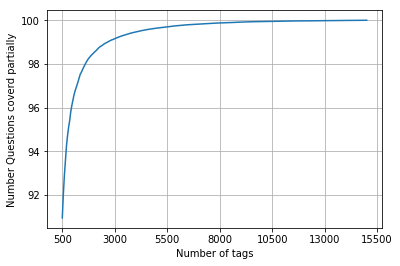

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [11]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)


In [12]:
x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:preprocessed_data.shape[0],:]

In [13]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [14]:
start = datetime.now()
vectorizer =CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(),  ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:08:28.230442


In [15]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


In [20]:
start = datetime.now()
alpha=[0.01,0.1,1,10]
for i in alpha:
    classifier_1 = OneVsRestClassifier(LogisticRegression(C=i,penalty='l1',tol=0.01))
    classifier_1.fit(x_train_multilabel, y_train)
    predictions_1 = classifier_1.predict(x_train_multilabel)
    predictions_2 = classifier_1.predict(x_test_multilabel)
    f1 = f1_score(y_train, predictions_1, average='micro')
    f2 = f1_score(y_test, predictions_2, average='micro')
    print("Micro-average quality numbers for C=",i)
    print(" F1-measure for train: {:.4f}".format( f1))
    print(" F1-measure for test: {:.4f}".format( f2))
print("Time taken to run this cell :", datetime.now() - start)

Micro-average quality numbers for C= 0.01
 F1-measure for train: 0.5028
 F1-measure for test: 0.4136
Micro-average quality numbers for C= 0.1
 F1-measure for train: 0.5734
 F1-measure for test: 0.4713
Micro-average quality numbers for C= 1
 F1-measure for train: 0.8988
 F1-measure for test: 0.4797
Micro-average quality numbers for C= 10
 F1-measure for train: 0.9980
 F1-measure for test: 0.4438
Time taken to run this cell : 9:08:56.071645


taking best C=0.01 

In [17]:
from sklearn.model_selection import GridSearchCV
classifier_2 = OneVsRestClassifier(SGDClassifier (loss='hinge',penalty='l1',tol=0.01))
params={'estimator__alpha':[0.01,0.1,1,10]}
grid_clf=GridSearchCV(classifier_2 ,param_grid=params,scoring='f1_micro')
grid_clf.fit(x_train_multilabel, y_train)
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Time taken to run this cell : 3:25:40.484281


In [19]:
print (grid_clf.best_params_)

{'estimator__alpha': 0.01}


In [21]:
classifier_3 = OneVsRestClassifier(SGDClassifier (alpha=0.01,loss='hinge',penalty='l1',tol=0.01))
classifier_3.fit(x_train_multilabel, y_train) 
predictions_1 = classifier_3.predict(x_train_multilabel)
predictions_2 = classifier_3.predict(x_test_multilabel)
f1 = f1_score(y_train, predictions_1, average='micro')
f2 = f1_score(y_test, predictions_2, average='micro')
print(" F1-measure for train: {:.4f}".format( f1))
print(" F1-measure for test: {:.4f}".format( f2))



 F1-measure for train: 0.3489
 F1-measure for test: 0.2165


In [23]:
from prettytable import PrettyTable

# Initializing table object
print("For tag prediction")
x = PrettyTable()

x.field_names = ["Model","hyparameter","train micro f1","test micro f1"]

x.add_row([ "logistic regression one vs rest","0.1","0.57","0.47" ])
x.add_row([ "linear svm one vs rest","0.01","0.34","0.21" ])
print(x)

For tag prediction
+---------------------------------+-------------+----------------+---------------+
|              Model              | hyparameter | train micro f1 | test micro f1 |
+---------------------------------+-------------+----------------+---------------+
| logistic regression one vs rest |     0.1     |      0.57      |      0.47     |
|      linear svm one vs rest     |     0.01    |      0.34      |      0.21     |
+---------------------------------+-------------+----------------+---------------+
